## Sitting Posture Detection Training

In [323]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

### Define Dataset class

In [324]:
class PostureDataset(Dataset):
    def __init__(self, data, scaler=None, label_encoder=None, from_csv=True):
        """
        Args:
        - data: CSV file path or DataFrame containing the dataset.
        - scaler: StandardScaler for feature normalization.
        - label_encoder: LabelEncoder for encoding the labels (not required if already encoded).
        - from_csv: Set to True if the input is a CSV path.
        """

        self.label_encoder = label_encoder

        # Load data
        if from_csv:
            data = pd.read_csv(data)
        
        # Ensure required columns are present
        if 'class' not in data.columns:
            raise ValueError("The input data must contain a 'class' column.")
        
        # Extract features and labels
        self.X = data.drop(columns=['class']).values  # Features
        self.y = data['class'].values  # Labels (already encoded)

        # Normalize features using StandardScaler
        if scaler:
            self.X = scaler.transform(self.X)
        else:
            self.scaler = StandardScaler()
            self.X = self.scaler.fit_transform(self.X)
        
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)  # Ensure labels are integers

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_class_label(self):
        """Print class encoding, actual labels"""
        class_labels = self.label_encoder.classes_

        print("\nClass Index to Label Mapping:")
        for idx, label in enumerate(class_labels):
            print(f"  {idx}: {label}")      

    def get_class_info(self):
        """Print number of samples per class."""
        class_labels = self.label_encoder.classes_
        
        print("\nNumber of Samples per Class:")
        class_counts = pd.Series(self.y.numpy()).value_counts()
        for idx, count in class_counts.items():
            print(f"  {idx} ({class_labels[idx]}): {count} samples")

### Define ANN Model Architecture

In [325]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),  # Increase neurons
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

### Define Utility Functions

1. Train test loss & accuracy plot
2. Confusion matrix
3. Classification report
4. Export model

In [326]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torch
import os

def plot_training_results(train_losses, train_accuracies, val_losses, val_accuracies, save_dir=None, use_cross_validation=False):
    """
    Plots the average train/test loss and accuracy.
    If `use_cross_validation` is True, axis titles will mention 'Average'.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Set appropriate labels
    loss_title = "Loss Curve" if not use_cross_validation else "Average Loss Curve"
    accuracy_title = "Accuracy Curve" if not use_cross_validation else "Average Accuracy Curve"
    train_label = "Train Loss" if not use_cross_validation else "Avg Train Loss"
    val_label = "Test Loss" if not use_cross_validation else "Avg Test Loss"
    train_acc_label = "Train Accuracy" if not use_cross_validation else "Avg Train Accuracy"
    val_acc_label = "Test Accuracy" if not use_cross_validation else "Avg Test Accuracy"

    # Plot Loss
    axes[0].plot(train_losses, label=train_label, color='blue')
    axes[0].plot(val_losses, label=val_label, color='orange')
    axes[0].set_title(loss_title)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Plot Accuracy
    axes[1].plot(train_accuracies, label=train_acc_label, color='blue')
    axes[1].plot(val_accuracies, label=val_acc_label, color='orange')
    axes[1].set_title(accuracy_title)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, "train_test_plot.png"))
    
    plt.show()
    
def plot_per_fold_results(per_fold_train_losses, per_fold_train_accuracies, per_fold_val_losses, per_fold_val_accuracies, save_dir=None):
    """
    Plots the average train/test loss and accuracy per fold.
    """
    folds = range(1, len(per_fold_train_losses) + 1)  # Fold numbers

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Loss per Fold
    axes[0].plot(folds, per_fold_train_losses, marker='o', label="Avg Train Loss", color='blue')
    axes[0].plot(folds, per_fold_val_losses, marker='o', label="Avg Test Loss", color='orange')
    axes[0].set_title("Loss per Fold")
    axes[0].set_xlabel("Fold")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Plot Accuracy per Fold
    axes[1].plot(folds, per_fold_train_accuracies, marker='o', label="Avg Train Accuracy", color='blue')
    axes[1].plot(folds, per_fold_val_accuracies, marker='o', label="Avg Test Accuracy", color='orange')
    axes[1].set_title("Accuracy per Fold")
    axes[1].set_xlabel("Fold")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, "per_fold_results.png"))
    
    plt.show()

def plot_confusion_matrix(model, data_loader, class_labels, device, save_dir=None, cross_val_results=None):
    """
    Generates and plots the confusion matrix.
    If cross-validation is used, it aggregates results from all folds and computes an average confusion matrix.
    """
    model.eval()
    all_preds, all_labels = [], []

    if cross_val_results:
        print("\nAggregating cross-validation results for confusion matrix...")
        # Check if the predictions and labels are already flat or need flattening
        if isinstance(cross_val_results['all_preds'][0], (list, np.ndarray)):
            # If they're lists of lists, flatten them
            for fold_preds, fold_labels in zip(cross_val_results['all_preds'], cross_val_results['all_labels']):
                all_preds.extend(fold_preds)
                all_labels.extend(fold_labels)
        else:
            # If they're already flat, just use them directly
            all_preds = cross_val_results['all_preds']
            all_labels = cross_val_results['all_labels']
    else:
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_labels)))

    # Normalize the confusion matrix (percentage form)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Calculate per-class accuracy
    class_accuracy = {}
    for i, label in enumerate(class_labels):
        true_positives = cm[i, i]
        total_samples = cm[i].sum()
        accuracy = (true_positives / total_samples) * 100 if total_samples > 0 else 0
        class_accuracy[label] = accuracy

    # Set title based on cross-validation
    matrix_title = "Confusion Matrix (Cross-Validation)" if cross_val_results else "Confusion Matrix"

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(matrix_title)

    if save_dir:
        plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    plt.show()

    # Print per-class accuracy
    print("\nPer-Class Accuracy:")
    for label, acc in class_accuracy.items():
        print(f"  {label}: {acc:.2f}%")
        
    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=class_labels)
    print("\nClassification Report:\n", report)

    if save_dir:
        with open(os.path.join(save_dir, "classification_report.txt"), "w") as f:
            f.write(report)

    return class_accuracy

def save_model_with_config(scaler, model, model_name, save_dir):
    """
    Save the PyTorch model state dictionary to a specified directory.
    Save scaler_mean and scaler_scale to the same directory.
    """
    # Save the model state dictionary
    model_path = os.path.join(save_dir, model_name)
    torch.save(model.state_dict(), model_path)

    # Save the scaler's mean and scale as NumPy arrays
    np.save(os.path.join(save_dir, "scaler_mean.npy"), scaler.mean_)
    np.save(os.path.join(save_dir, "scaler_scale.npy"), scaler.scale_)

    print(f"Model saved to: {model_path}")
    print(f"Scaler mean saved to: {os.path.join(save_dir, 'scaler_mean.npy')}")
    print(f"Scaler scale saved to: {os.path.join(save_dir, 'scaler_scale.npy')}")


### Define the Training & Evaluation Function

In [327]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Initialize lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_acc = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        
        # Validation Phase
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_acc = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        # Print epoch stats
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Val Acc: {val_accuracies[-1]:.4f}")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

def train_model_with_cross_validation(model, dataset, criterion, optimizer, epochs, k_folds=5):
    """
    Train model using k-fold cross-validation and return averaged training and validation metrics.
    Also stores and prints per-fold average metrics and returns them for visualization.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Store sum of metrics across folds (to compute averages)
    total_train_losses = np.zeros(epochs)
    total_train_accuracies = np.zeros(epochs)
    total_val_losses = np.zeros(epochs)
    total_val_accuracies = np.zeros(epochs)

    # Store all predictions and labels for final confusion matrix
    all_preds, all_labels = [], []  

    # Store per-fold average metrics
    per_fold_train_losses = []
    per_fold_train_accuracies = []
    per_fold_val_losses = []
    per_fold_val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Training on Fold {fold + 1}/{k_folds}...")

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

        # Reset model parameters for each fold
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        model.to(device)

        # Train and get metrics for this fold
        train_losses, train_accuracies, val_losses, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, epochs
        )

        # Sum up the results to later compute averages
        total_train_losses += np.array(train_losses) 
        total_train_accuracies += np.array(train_accuracies)
        total_val_losses += np.array(val_losses)
        total_val_accuracies += np.array(val_accuracies)

        # Compute and store the average per-fold metrics
        avg_train_loss = np.mean(train_losses)
        avg_train_acc = np.mean(train_accuracies)
        avg_val_loss = np.mean(val_losses)
        avg_val_acc = np.mean(val_accuracies)

        per_fold_train_losses.append(avg_train_loss)
        per_fold_train_accuracies.append(avg_train_acc)
        per_fold_val_losses.append(avg_val_loss)
        per_fold_val_accuracies.append(avg_val_acc)

        print(f"Fold {fold + 1}: Avg Train Loss = {avg_train_loss:.4f}, Avg Train Acc = {avg_train_acc:.4f}, "
              f"Avg Test Loss = {avg_val_loss:.4f}, Avg Test Acc = {avg_val_acc:.4f}")

        # Collect predictions and labels for this fold
        fold_preds, fold_labels = [], []
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                fold_preds.extend(preds.cpu().numpy())
                fold_labels.extend(labels.cpu().numpy())

        all_preds.append(fold_preds)
        all_labels.append(fold_labels)

    # Compute the average metrics across all folds
    avg_train_losses = total_train_losses / k_folds
    avg_train_accuracies = total_train_accuracies / k_folds
    avg_val_losses = total_val_losses / k_folds
    avg_val_accuracies = total_val_accuracies / k_folds

    return {
        "train_losses": avg_train_losses.tolist(),
        "train_accuracies": avg_train_accuracies.tolist(),
        "val_losses": avg_val_losses.tolist(),
        "val_accuracies": avg_val_accuracies.tolist(),
        "all_preds": all_preds,
        "all_labels": all_labels,
        "per_fold_train_losses": per_fold_train_losses,  
        "per_fold_train_accuracies": per_fold_train_accuracies,
        "per_fold_val_losses": per_fold_val_losses,
        "per_fold_val_accuracies": per_fold_val_accuracies,
    }



### Load Preprocessed Dataset

In [328]:
# Load and preprocess data
csv_path = "../../datasets/vectors/augmented_xy_filtered_keypoints_vectors_mediapipe.csv"
df = pd.read_csv(csv_path)  

print("Number of samples per class before train test split:")
print(df['class'].value_counts())

Number of samples per class before train test split:
class
crossed_legs    1091
proper          1084
slouching       1000
reclining        970
Name: count, dtype: int64


### Encode Class Labels

In [329]:
# Encode class labels to integers using LabelEncoder
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

### Train Test Split

In [330]:

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

BATCH_SIZE = 32

# Split the data into training and test datasets
train_data, test_data = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)

### Feature Normalisation using StandardScaler

In [331]:
# Standardize features
scaler = StandardScaler()
train_features = train_data.drop(columns=['class']).values
scaler.fit(train_features)

StandardScaler()

### Apply SMOTE to address class imbalanced

In [332]:
""" APPLY SMOTE
train_labels = train_data['class'].values
print("\n------------------------------------")
print(f"Training samples before SMOTE: {len(train_data)}")
print(f"Class distribution before SMOTE: {Counter(train_labels)}")

smote = SMOTE(random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(train_features, train_labels)

print("\n------------------------------------")
print(f"Training samples after SMOTE: {len(X_resampled)}")
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Convert resampled data back to a DataFrame
train_data = pd.DataFrame(X_resampled, columns=train_data.columns[:-1])  # Feature columns
train_data["class"] = y_resampled  # Add the resampled class labels
"""

' APPLY SMOTE\ntrain_labels = train_data[\'class\'].values\nprint("\n------------------------------------")\nprint(f"Training samples before SMOTE: {len(train_data)}")\nprint(f"Class distribution before SMOTE: {Counter(train_labels)}")\n\nsmote = SMOTE(random_state=RANDOM_SEED)\nX_resampled, y_resampled = smote.fit_resample(train_features, train_labels)\n\nprint("\n------------------------------------")\nprint(f"Training samples after SMOTE: {len(X_resampled)}")\nprint(f"Class distribution after SMOTE: {Counter(y_resampled)}")\n\n# Convert resampled data back to a DataFrame\ntrain_data = pd.DataFrame(X_resampled, columns=train_data.columns[:-1])  # Feature columns\ntrain_data["class"] = y_resampled  # Add the resampled class labels\n'

### Create DataLoaders

In [333]:
# Create datasets and loaders
train_dataset = PostureDataset(train_data, scaler=scaler, label_encoder=label_encoder, from_csv=False)
print("Class Label Mapping: ")
train_dataset.get_class_label()
print("\n------------------------------------")
print("Training dataset:")
train_dataset.get_class_info()
print("\n------------------------------------")
test_dataset = PostureDataset(test_data, scaler=scaler, label_encoder=label_encoder, from_csv=False)
print("Testing dataset:")
test_dataset.get_class_info()
print("\n------------------------------------")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Class Label Mapping: 

Class Index to Label Mapping:
  0: crossed_legs
  1: proper
  2: reclining
  3: slouching

------------------------------------
Training dataset:

Number of Samples per Class:
  1 (proper): 760 samples
  0 (crossed_legs): 736 samples
  3 (slouching): 733 samples
  2 (reclining): 672 samples

------------------------------------
Testing dataset:

Number of Samples per Class:
  0 (crossed_legs): 355 samples
  1 (proper): 324 samples
  2 (reclining): 298 samples
  3 (slouching): 267 samples

------------------------------------


### Initialise Model

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.005
NUM_CLASSES = 4
EPOCHS = 300

# Model initialization
input_size = train_features.shape[1]
model = MLP(input_size, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

### Train Model and Plot Results

Training on Fold 1/5...
Epoch [1/10], Train Loss: 0.9380, Train Acc: 0.6119, Val Loss: 0.6776, Val Acc: 0.7394
Epoch [2/10], Train Loss: 0.7151, Train Acc: 0.7147, Val Loss: 0.5498, Val Acc: 0.7889
Epoch [3/10], Train Loss: 0.6205, Train Acc: 0.7434, Val Loss: 0.5177, Val Acc: 0.8082
Epoch [4/10], Train Loss: 0.6088, Train Acc: 0.7509, Val Loss: 0.4824, Val Acc: 0.8118
Epoch [5/10], Train Loss: 0.5815, Train Acc: 0.7678, Val Loss: 0.4875, Val Acc: 0.8034
Epoch [6/10], Train Loss: 0.5397, Train Acc: 0.7874, Val Loss: 0.4688, Val Acc: 0.8130
Epoch [7/10], Train Loss: 0.5255, Train Acc: 0.7901, Val Loss: 0.4405, Val Acc: 0.8372
Epoch [8/10], Train Loss: 0.5118, Train Acc: 0.8055, Val Loss: 0.4335, Val Acc: 0.8239
Epoch [9/10], Train Loss: 0.5020, Train Acc: 0.7992, Val Loss: 0.4071, Val Acc: 0.8552
Epoch [10/10], Train Loss: 0.4959, Train Acc: 0.8046, Val Loss: 0.4227, Val Acc: 0.8275
Fold 1: Avg Train Loss = 0.6039, Avg Train Acc = 0.7575, Avg Test Loss = 0.4888, Avg Test Acc = 0.8109
Tr

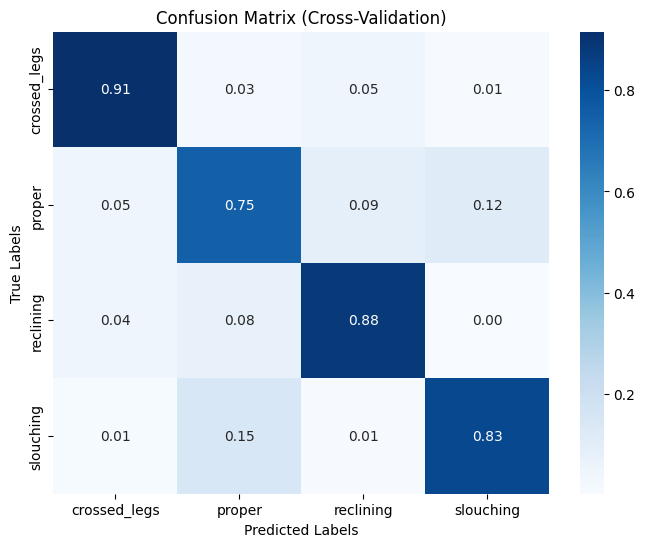


Per-Class Accuracy:
  crossed_legs: 91.48%
  proper: 74.54%
  reclining: 87.73%
  slouching: 83.20%

Classification Report:
               precision    recall  f1-score   support

crossed_legs       0.91      0.91      0.91      1091
      proper       0.76      0.75      0.75      1084
   reclining       0.84      0.88      0.86       970
   slouching       0.85      0.83      0.84      1000

    accuracy                           0.84      4145
   macro avg       0.84      0.84      0.84      4145
weighted avg       0.84      0.84      0.84      4145



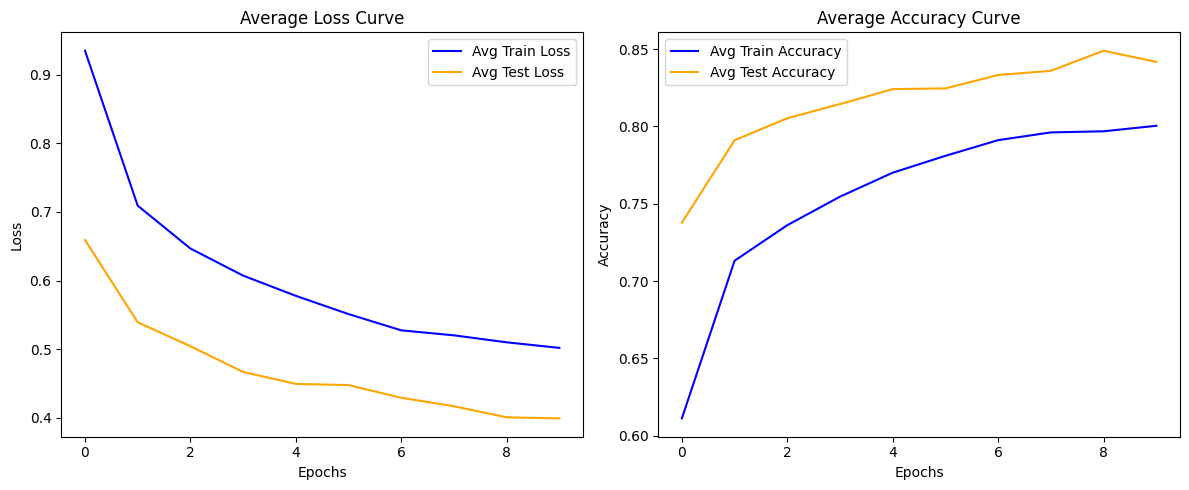

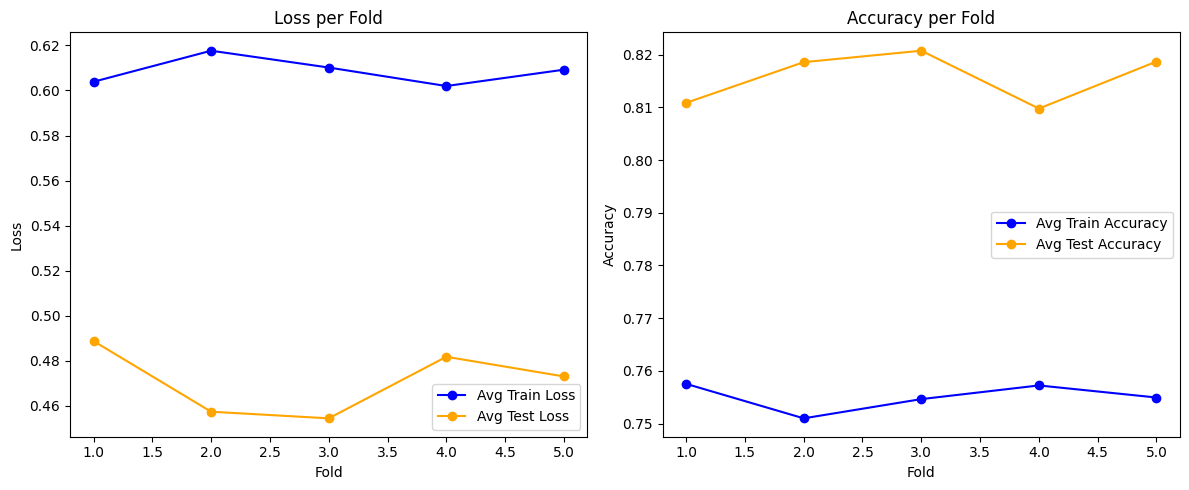


Cross-Validation Results per Fold:
|   Fold |   Train Loss |   Train Acc |   Test Loss |   Test Acc |
|--------|--------------|-------------|-------------|------------|
|      1 |       0.6039 |      0.7575 |      0.4888 |     0.8109 |
|      2 |       0.6177 |      0.751  |      0.4574 |     0.8186 |
|      3 |       0.6102 |      0.7546 |      0.4545 |     0.8207 |
|      4 |       0.602  |      0.7572 |      0.4818 |     0.8098 |
|      5 |       0.6092 |      0.7549 |      0.4731 |     0.8187 |

Final Cross-Validation Averages:
|         |   Train Loss |   Train Acc |   Test Loss |   Test Acc |
|---------|--------------|-------------|-------------|------------|
| Overall |       0.6086 |      0.7551 |      0.4711 |     0.8157 |


In [335]:
import datetime
import torch
import os
from tabulate import tabulate

USE_CROSS_VALIDATION = True  # Set to True to enable k-fold cross-validation
SAVE_RESULT = False
MODEL_NAME = "epochs_300_lr_1e-03_wd_1e-02_acc_9581.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_labels = label_encoder.classes_

# Create save directory if needed
save_dir = None
if SAVE_RESULT:
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join("../models", timestamp)
    os.makedirs(save_dir, exist_ok=True)

if USE_CROSS_VALIDATION:
    dataset = torch.utils.data.ConcatDataset([train_loader.dataset, test_loader.dataset])
    cross_val_results = train_model_with_cross_validation(model, dataset, criterion, optimizer, epochs=EPOCHS, k_folds=5)

    # Check if the structure is correct before flattening
    if isinstance(cross_val_results["all_preds"][0], (list, np.ndarray)):
        # Flatten the lists of lists to a single list
        aggregated_results = {
            "all_preds": [pred for fold_preds in cross_val_results["all_preds"] for pred in fold_preds],
            "all_labels": [label for fold_labels in cross_val_results["all_labels"] for label in fold_labels]
        }
    else:
        # Already flat, just use directly
        aggregated_results = {
            "all_preds": cross_val_results["all_preds"],
            "all_labels": cross_val_results["all_labels"]
        }

    # Plot confusion matrix with aggregated predictions and labels
    plot_confusion_matrix(
        model, None, class_labels, device, 
        save_dir=save_dir, 
        cross_val_results=aggregated_results
    )

    # Plot averaged training results
    plot_training_results(
        cross_val_results["train_losses"],
        cross_val_results["train_accuracies"],
        cross_val_results["val_losses"],
        cross_val_results["val_accuracies"],
        save_dir=save_dir,
        use_cross_validation=True
    )
    
    # Plot per-fold metrics
    plot_per_fold_results(
        cross_val_results["per_fold_train_losses"],
        cross_val_results["per_fold_train_accuracies"],
        cross_val_results["per_fold_val_losses"],
        cross_val_results["per_fold_val_accuracies"],
        save_dir=save_dir
    )

    # Extract per-fold metrics
    per_fold_train_losses = cross_val_results["per_fold_train_losses"]
    per_fold_train_accuracies = cross_val_results["per_fold_train_accuracies"]
    per_fold_val_losses = cross_val_results["per_fold_val_losses"]
    per_fold_val_accuracies = cross_val_results["per_fold_val_accuracies"]

    # Prepare tabulated per-fold results
    table_data = []
    for i in range(len(per_fold_train_losses)):
        table_data.append([
            i + 1,
            f"{per_fold_train_losses[i]:.4f}",
            f"{per_fold_train_accuracies[i]:.4f}",
            f"{per_fold_val_losses[i]:.4f}",
            f"{per_fold_val_accuracies[i]:.4f}"
        ])

    # Compute overall averages
    avg_train_loss = np.mean(per_fold_train_losses)
    avg_train_acc = np.mean(per_fold_train_accuracies)
    avg_val_loss = np.mean(per_fold_val_losses)
    avg_val_acc = np.mean(per_fold_val_accuracies)

    # Print per-fold table
    print("\nCross-Validation Results per Fold:")
    print(tabulate(table_data, headers=["Fold", "Train Loss", "Train Acc", "Test Loss", "Test Acc"], tablefmt="github"))

    # Print overall results
    overall_table = [
        ["Overall", f"{avg_train_loss:.4f}", f"{avg_train_acc:.4f}", f"{avg_val_loss:.4f}", f"{avg_val_acc:.4f}"]
    ]

    print("\nFinal Cross-Validation Averages:")
    print(tabulate(overall_table, headers=[" ", "Train Loss", "Train Acc", "Test Loss", "Test Acc"], tablefmt="github"))

else:
    # Standard training process
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(
        model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS
    )

    # Plot training results
    plot_training_results(train_losses, train_accuracies, val_losses, val_accuracies, save_dir=save_dir)

    # Plot confusion matrix for test dataset
    plot_confusion_matrix(model, test_loader, class_labels, device, save_dir=save_dir)

# Save model if needed
if SAVE_RESULT:
    save_model_with_config(scaler, model, MODEL_NAME, save_dir)
